## offline eval lerobot_dp

In [6]:
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
import random, os
import numpy as np
import matplotlib.pyplot as plt

home_path = os.path.expanduser("~")
root = os.path.join(home_path, "mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot") 
parts = root.split("/")[-3:]
repo_id = '_'.join(parts[:2]) + '/' + parts[2]
local_files_only = True

dataset = LeRobotDataset(repo_id=repo_id, local_files_only=local_files_only, root=root)
num_episodes = dataset.episode_data_index["from"].shape[0]
def pick_one_episode(episode_index, dataset):
    from_idx = dataset.episode_data_index["from"][episode_index].item()
    to_idx = dataset.episode_data_index["to"][episode_index].item()
    
    timestamps = [x / dataset.fps for x in range(to_idx - from_idx)]
    delta_timestamps = {
        "observation.state": timestamps,
        # "observation.images.head_cam_l": timestamps,
        "observation.images.wrist_cam_r": timestamps,
        # "observation.images.wrist_cam_l": timestamps,
        "observation.images.head_cam_h": timestamps,
        "action": timestamps,
    }
    val_dataset = LeRobotDataset(repo_id=repo_id, local_files_only=local_files_only, root=root, delta_timestamps=delta_timestamps)
    one_eps = val_dataset.get_one_episode(val_dataset.episode_data_index["from"][episode_index].item())
    
    return one_eps
select_num = 2
selected_episodes = random.sample(range(num_episodes), select_num) if num_episodes >= select_num else list(range(num_episodes))
for episode_index in selected_episodes:
    one_eps = pick_one_episode(episode_index, dataset)
    print(f"Episode {episode_index} has {len(one_eps['observation.state'])} frames")
    break

Returning existing local_dir `/home/lejurobot/mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/lejurobot/mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).


Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Returning existing local_dir `/home/lejurobot/mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).
Returning existing local_dir `/home/lejurobot/mydisk/data/Task23_Orbber_conveyor_black/v0/lerobot` as remote repo cannot be accessed in `snapshot_download` (None).


Resolving data files:   0%|          | 0/97 [00:00<?, ?it/s]

Episode 82 has 148 frames


In [7]:

act_sequencia = one_eps['action'][:, :]
obs_sequencia = {
    "observation.state": one_eps['observation.state'][:, :],
    # "observation.images.cam_h": one_eps['observation.images.cam_h'],
    "observation.images.head_cam_h": one_eps['observation.images.head_cam_h'],
    # "observation.images.wrist_cam_l": one_eps['observation.images.wrist_cam_l'],
    "observation.images.wrist_cam_r": one_eps['observation.images.wrist_cam_r'],
    # "observation.images.right": one_eps['observation.images.right'],
}
print(obs_sequencia['observation.state'].shape, act_sequencia.shape)
from collections import defaultdict
import torch
all_img: defaultdict[str, list] = defaultdict(list)
upBody_lowDim: defaultdict[str, list] = defaultdict(list)

for key in obs_sequencia.keys():
    if 'observation.images' in key:
        all_img[key].append(np.array(obs_sequencia[key]))
    elif 'observation.state' in key:
        upBody_lowDim["true_states"].append(np.array(obs_sequencia[key]))
upBody_lowDim['true_actions'].append(np.array(act_sequencia))

def process_images_from_tensor_to_uint8(all_img):
    for img_eps in all_img.values():
        for i in range(len(img_eps)):
            if isinstance(img_eps[i], torch.Tensor):
                img_eps[i] = img_eps[i].cpu().numpy()  # 先转为 NumPy 数组
                img_eps[i] = np.array([
                    np.transpose((img * 255).clip(0, 255).astype(np.uint8), (1, 2, 0))
                    for img in img_eps[i]
                ])
            else:
                img_eps[i] = np.array([
                    np.transpose((img * 255).clip(0, 255).astype(np.uint8), (1, 2, 0))
                    for img in img_eps[i]
                ])
    return all_img
all_img = process_images_from_tensor_to_uint8(all_img)

for k,v in upBody_lowDim.items():
    print(k, len(v), v[0].shape)
for k, v in all_img.items():
    print(k, len(v), v[0].shape)

torch.Size([148, 8]) torch.Size([148, 8])
true_states 1 (148, 8)
true_actions 1 (148, 8)
observation.images.head_cam_h 1 (148, 480, 640, 3)
observation.images.wrist_cam_r 1 (148, 480, 640, 3)


In [11]:
def draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx = None):
    import numpy as np
    import matplotlib.pyplot as plt
    img_strips = []
    show_img_num = 18
    for img_name, img_eps in all_img.items():
        img_strip = np.concatenate(np.array(img_eps[eps_idx])[::len(img_eps[eps_idx])//show_img_num], axis=1)  # Row for images
        img_strips.append(img_strip)

    img_strip_combined = np.vstack(img_strips)
    
    JOINT_DIM_LABELS= ["zarm_l1_link", "zarm_l2_link", "zarm_l3_link", "zarm_l4_link", "zarm_l5_link", "zarm_l6_link", "zarm_l7_link", 
                  "dex_hand_l1_link", "dex_hand_l2_link", "dex_hand_l3_link", "dex_hand_l4_link", "dex_hand_l5_link", "dex_hand_l6_link", 
                  "zarm_r1_link", "zarm_r2_link", "zarm_r3_link", "zarm_r4_link", "zarm_r5_link", "zarm_r6_link", "zarm_r7_link", 
                  "dex_hand_r1_link", "dex_hand_r2_link", "dex_hand_r3_link", "dex_hand_r4_link", "dex_hand_r5_link", "dex_hand_r6_link", 
                  ] 
    img_rows = len(all_img)
    figure_layout = [
            JOINT_DIM_LABELS[:7],
            JOINT_DIM_LABELS[7:13] + ['extra1'],
            JOINT_DIM_LABELS[13:-6] ,
            JOINT_DIM_LABELS[-6:]+ ['extra2'],
        ]
    for i in range(img_rows):
        row_images = ['image'] * len(JOINT_DIM_LABELS[:7])
        figure_layout.insert(i, row_images)


    plt.rcParams.update({'font.size': 7})
    fig, axs = plt.subplot_mosaic(figure_layout)
    fig.set_size_inches([30, 15]) 
    fig.suptitle(task_name, fontsize=15)
    
    if slice_idx is not None:
        SELECTED_JOINT = [x for slc in slice_idx for x in JOINT_DIM_LABELS[slc[0]:slc[1]]]
    else:
        SELECTED_JOINT = JOINT_DIM_LABELS[0:8] + JOINT_DIM_LABELS[13:21] 
    for action_dim, action_label in enumerate(SELECTED_JOINT):
        for low_dim_name, low_dim_values in upBody_lowDim.items():
            if 'pred' in low_dim_name:  
                # selected_range = range(len(low_dim_values[eps_idx]) - 8 -50)  # len(low_dim_values[eps_idx]) - 8
                # draw_pred_num = 2
                # for j in selected_range:  # select range
                #     x_range = np.arange(j, j + min(draw_pred_num, 8))  
                #     y_values = low_dim_values[eps_idx][j, :draw_pred_num, action_dim]  
                #     axs[action_label].plot(x_range, y_values,  alpha=0.5, zorder=1)
                axs[action_label].plot(low_dim_values[eps_idx][:, 0, action_dim], label=low_dim_name, alpha=1, zorder=1)

            elif 'true_actions' in low_dim_name:    # (n, 26)
                axs[action_label].plot(low_dim_values[eps_idx][:, action_dim], label=low_dim_name, alpha=0.5, zorder=1)
                
            elif 'true_states' in low_dim_name:
                axs[action_label].plot(low_dim_values[eps_idx][:, action_dim], label=low_dim_name, alpha=0.2, zorder=1)
        axs[action_label].set_xlabel(action_label, labelpad=5)  
        # axs[action_label].set_xlabel('Time in one episode')
        axs[action_label].legend()

    axs['image'].imshow(img_strip_combined)
    # axs['image'].set_xlabel('Time in one episode (subsampled)')
    # axs['image'].set_title('Image Comparison')

    plt.legend()
    plt.show()


In [12]:
for k,v in upBody_lowDim.items():
    print(k, len(v), v[0].shape)

for k, v in all_img.items():
    print(k, len(v), v[0].shape)



true_states 1 (148, 8)
true_actions 1 (148, 8)
observation.images.head_cam_h 1 (148, 480, 640, 3)
observation.images.wrist_cam_r 1 (148, 480, 640, 3)


/tmp/ipykernel_3571319/1047429686.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


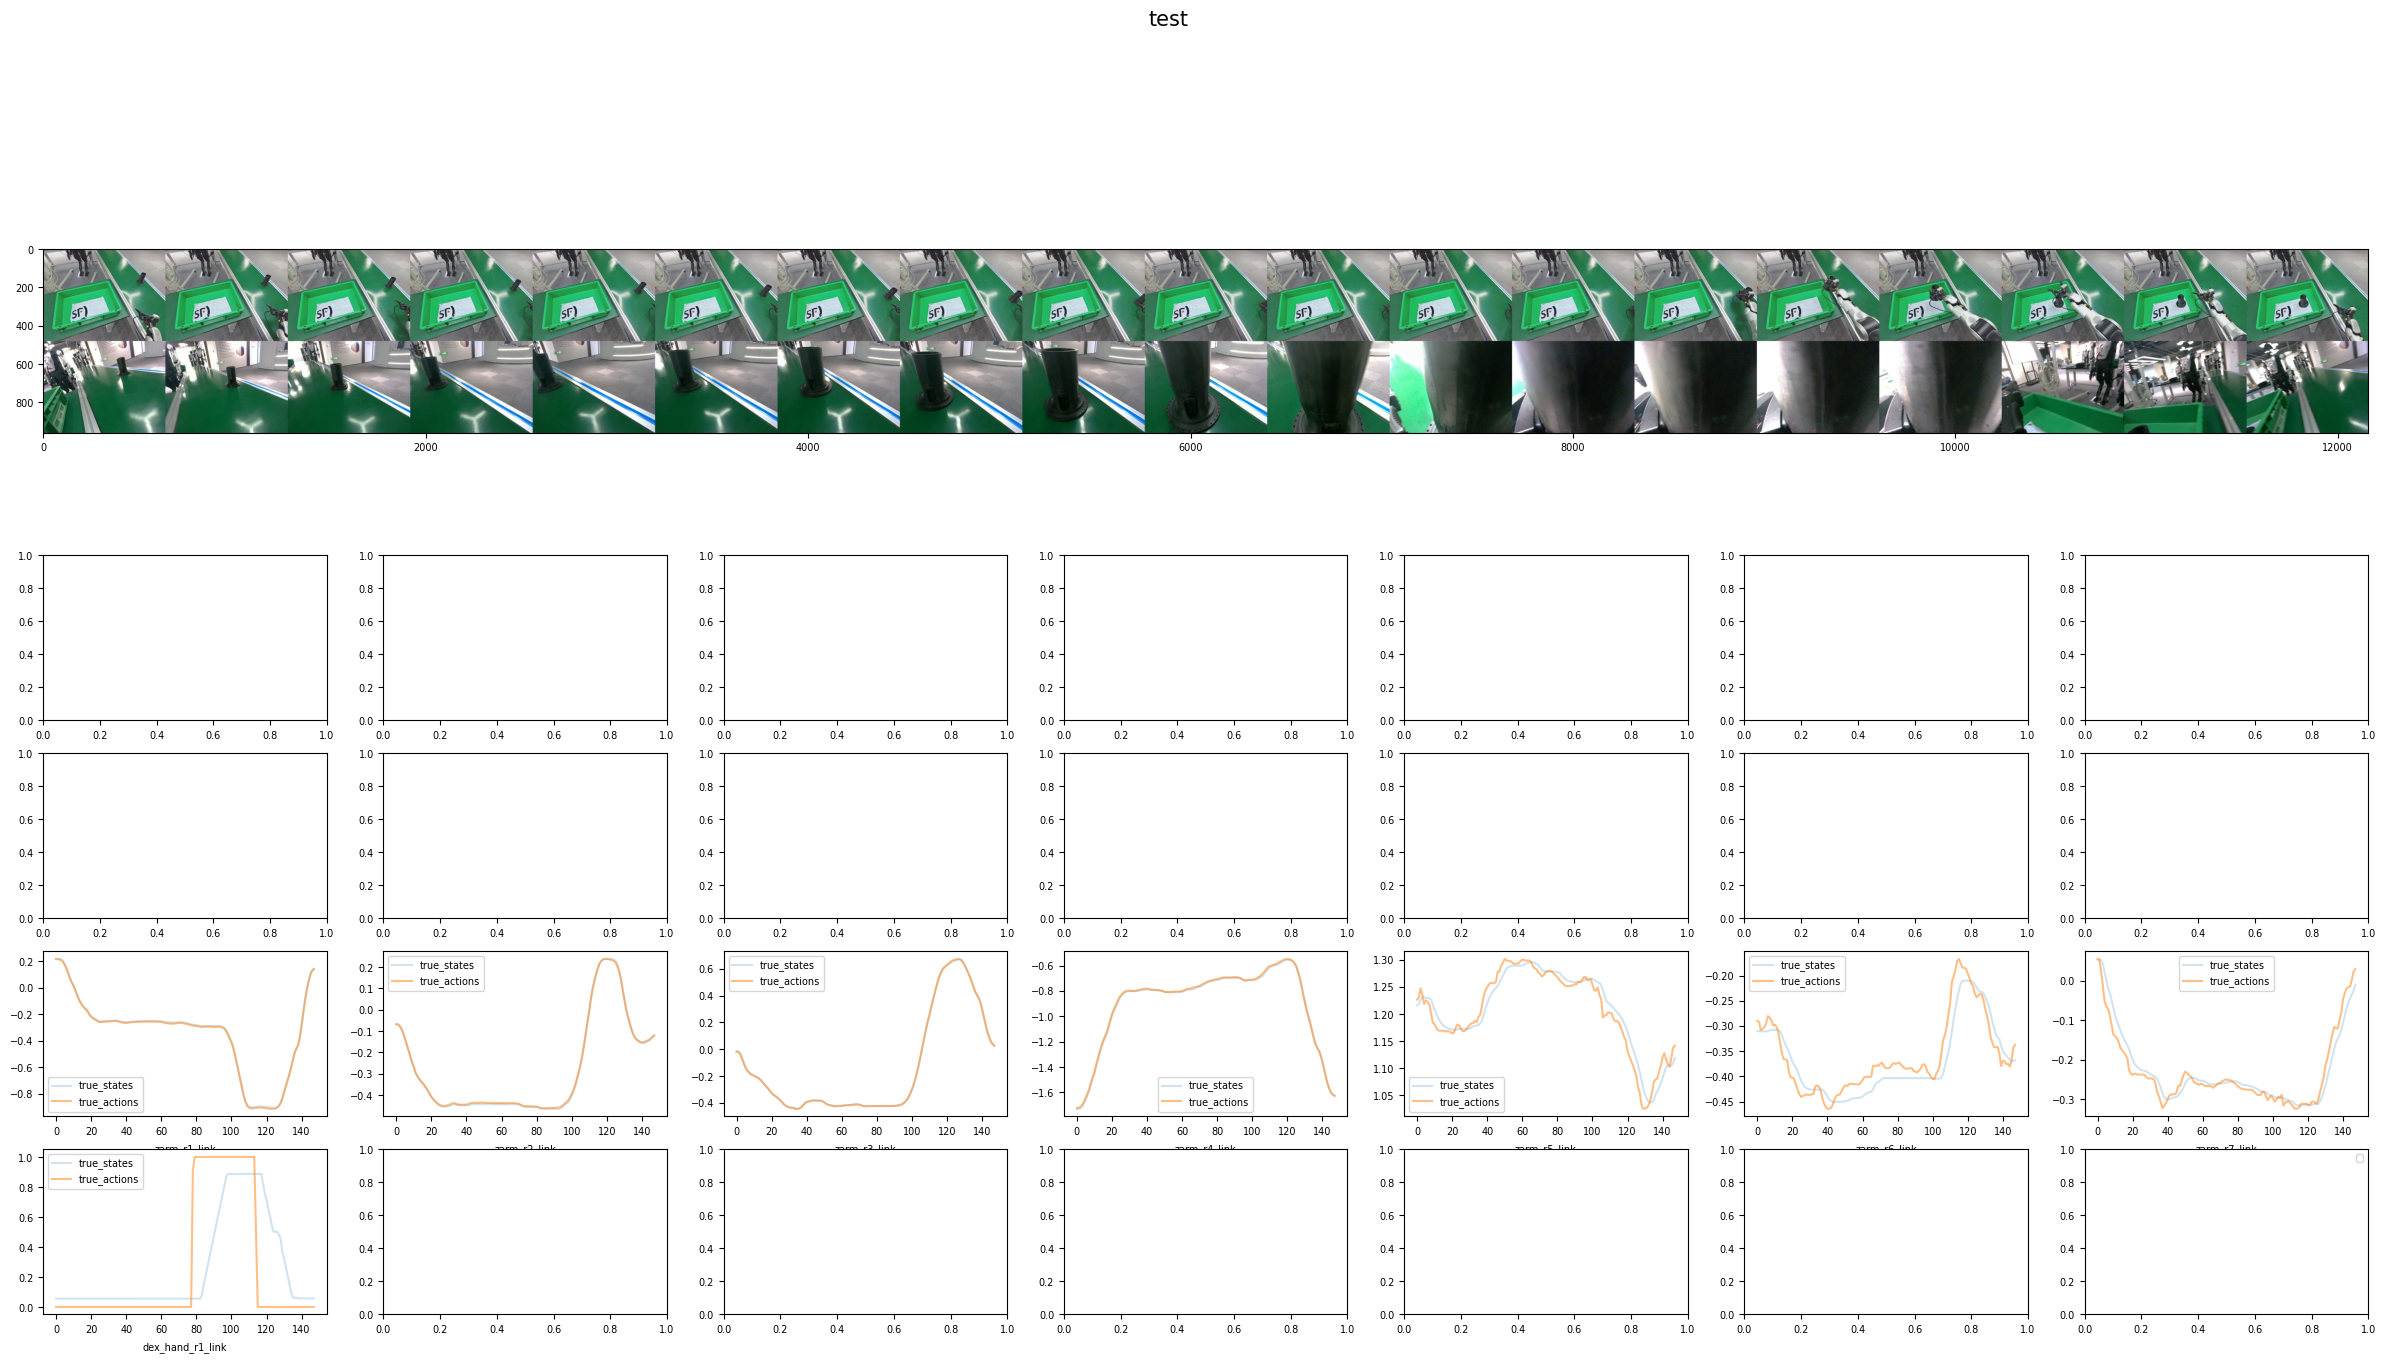

In [14]:
task_name = 'test'
slc = [(0, 0), (13, 21)]
for eps_idx in range(len(next(iter(all_img.values())))):
    draw_predicted_result(task_name, all_img, upBody_lowDim, eps_idx, slice_idx=slc)